In [1]:

#alguns imports

import sys
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.types import *

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1653431601335_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#criar uma instância SparkSession

#spark = SparkSession\
    #.builder\
    #.appName("Dataset")\
    #.config("spark.sql.shuffle.partitions",6)\
    #.config("spark.sql.repl.eagerEval.enabled", True)\
    #.getOrCreate()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:

#Leitura de todos os ficheiros de observações do dataset
df_raw = spark.read.csv("s3://bigdatanoaa/Dataset/", header="false", inferSchema="true", sep=",")   

#Renomeação das colunas
df_raw = df_raw.toDF("ID", "DATE", "ELEMENT", "DATA VALUE", "MFLAG", "QFLAG", "SFLAG", "OBS_TIME")  

#Leitura dos dados relativos aos países
df_countries = spark.read.csv("s3://bigdatanoaa/ghcnd-countries.csv", header="false", inferSchema="true", sep=";")

#Renomeação das colunas
df_countries = df_countries.toDF("CODIGO","PAIS","CONTINENTE")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:

#colunas irrelevantes
cols_to_drop = ['MFLAG', 'QFLAG', 'SFLAG', 'OBS_TIME']

#colunas de interesse
cols_interest = [x for x in df_raw.columns if x not in cols_to_drop]

#eliminação das colunas irrelevantes
df_raw_interest = df_raw.select(cols_interest)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:

#Passagem das datas para forma de data de modo a conseguirmos comparar as datas
new_date = df_raw_interest.withColumn("DATE",to_date(col("DATE").cast(StringType()),"yyyyMMdd"))

#Filtragem de modo a obter todas as observações registadas nos últimos 50 anos
df_filter = new_date.filter(((year(col("DATE")))>1970) & ((year(col("DATE")))<2022))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:

# Os valores correspondentes às temperaturas e preciciptação apresentam inicialmente um formato de tenth of degrees
# É preciso dividir esses valores por 10 de modo a obter o valor em graus centígrados

df_raw_interest = df_filter.withColumn("DATA VALUE",
    when((col("ELEMENT") == "TMAX")|(col("ELEMENT") == "TMIN")|(col("ELEMENT") == "TAVG")|(col("ELEMENT") == "PRCP"),
    round((col("DATA VALUE")/10),2)).otherwise(col("DATA VALUE")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:

#Adicionar o nome dos países de modo a associarmos o id da estação meteorológica ao seu respetivo país
new_data = df_raw_interest.join(df_countries).where(df_raw_interest["ID"].substr(1,2) == df_countries["CODIGO"]).drop(df_raw["ID"])

#Filtramos apenas os valores correspondentes à temperatura média
df_avg = new_data.filter(col("ELEMENT") == "TAVG")

#É feito o cálculo do valor da temperatura média em todos os países, sendo que filtramos apenas o de Portugal 
#O valor obtido mostra o valor da temperatura média registado nos últimos 50 anos em Portugal
df_avg.groupBy("PAIS").avg("DATA VALUE").filter(col("PAIS") == "Portugal").show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----------------+
|    PAIS|  avg(DATA VALUE)|
+--------+-----------------+
|Portugal|17.06844705666268|
+--------+-----------------+

In [8]:

#Valor da temperatura média, em Portugal, para cada ano durante os últimos 50 anos
df_avg_year = df_avg.groupBy("PAIS",year(col("DATE"))).avg("DATA VALUE").filter(col("PAIS") == "Portugal")

#Renomeação de colunas
df_avg_year = df_avg_year.toDF("PAIS","ANO","TEMPERATURA MEDIA")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

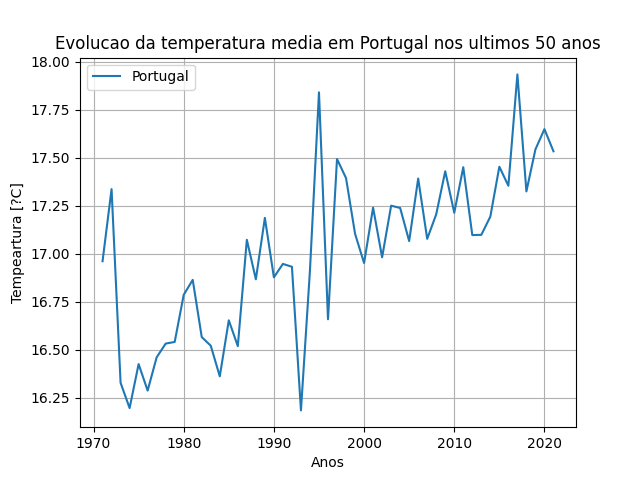

In [10]:

#Ordenação por ordem crescente de ano
df_plot = df_avg_year.orderBy("ANO",ascending=True).toPandas()

#Construção do gráfico da evolução da temperatura média em Portugal nos últimos 50 anos

plt.plot(figsize=(28,8))
sns.lineplot(data=df_plot, x='ANO', y='TEMPERATURA MEDIA', label='Portugal')
plt.title("Evolucao da temperatura media em Portugal nos ultimos 50 anos")
plt.xlabel("Anos")
plt.ylabel("Tempeartura [°C]")
plt.legend()
plt.grid()
plt.show()

%matplot plt
